<a href="https://colab.research.google.com/github/piccoripico/etc/blob/master/Whisper_(shared).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使い方


1.   文字起こししたいファイルを用意する（音声ファイル又は動画ファイル）
2.   実行ボタンをクリック（左下のこのボタン→）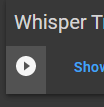
1.   ファイルをアップロード（実行後に下部に表示されるボタンから）
2.   文字起こしテキストファイルが出力されるまで待つ（90分のファイルなら30分～1時間？）


*   複数ファイル一括アップロード可
*   isTimeフラグ　ダウンロードするテキストファイルに開始時間情報を追加
*   isRawDataTableフラグ　生データをエクセルファイルでダウンロード
*   Google Colabの利用状況が重いか文字起こしの負荷をかけすぎると処理が止まるかも（CUDA out of memory error）→その場合は一旦Disconnectしてやり直し

In [ ]:
#@title Whisper Transcription

# 議事録音声ファイルのアップロード
from google.colab import files
import sys

def upload_files():
    uploaded_files = files.upload()
    if not uploaded_files:
        print("No file was uploaded. Exiting the program.")
        sys.exit()
    return uploaded_files

uploaded = upload_files()

# Colab上のパスを格納
meeting_file_paths = []
for meeting_file_name in uploaded.keys():
    meeting_file_path = "/content/" + meeting_file_name
    meeting_file_paths.append(meeting_file_path)

# https://internet.watch.impress.co.jp/docs/column/teleworkstory/1452677.html
# https://qiita.com/sakasegawa/items/3855472a8566ea302a99
# WhisperのモデルはGihHubのページ参照（時間がかかるがLargeでないと日本語の文字起こしは難しい模様）
!pip install openai
!pip install git+https://github.com/openai/whisper.git
import whisper
model = whisper.load_model("large")

# 格納したパスごとに処理
import datetime
for meeting_file_path in meeting_file_paths:
    # Whisper実行 
    transcribe = model.transcribe(meeting_file_path)

    # 処理結果ファイルのsegmentsのtextごとに改行
    transcript = ""
    isTime = True #@param {type:"boolean"}
    if isTime:
        for seg in transcribe['segments']:
            # 秒数を時間、分、秒に分解する
            hours, remainder = divmod(seg['start'], 3600)
            minutes, seconds = divmod(remainder, 60)
            # datetimeオブジェクトを作成する
            seg_time = datetime.time(hour=int(hours), minute=int(minutes), second=int(seconds))
            # 時刻の文字列を作成する
            seg_time = seg_time.strftime('%H:%M:%S')

            transcript += "[" + seg_time + "] " + seg['text'] + "\n"
    else:
        for seg in transcribe['segments']:
            transcript += seg['text'] + "\n"

    # Colabにプリント
    # print(transcribe)
    # print(transcript)

    # txtファイルを作成してダウンロード
    meeting_text = meeting_file_path + '.txt'
    with open(meeting_text, 'w') as f:
        f.writelines(transcript)
    files.download(meeting_text)

    # 生データをテーブル表示で見る
    # https://tech.briswell.com/entry/2022/09/28/192306
    # https://www.yutaka-note.com/entry/pandas_to_excel
    isRawDataTable = True #@param {type:"boolean"}
    if isRawDataTable:
        import pandas as pd
        df = pd.DataFrame(transcribe["segments"])[["id", "seek", "start", "end", "text", "tokens", "temperature", "avg_logprob", "compression_ratio", "no_speech_prob"]]
        # print(df)
        meeting_table = meeting_file_path + '.xlsx'
        df.to_excel(meeting_table, index=False)
        files.download(meeting_table)